# Advanced Lane finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Compute the camera calibration matrix and distortion coefficients from chessboard images 

In the next cells the following is done:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.


In [68]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import Line
%matplotlib qt
%matplotlib inline

In [7]:
def GetImageAndObjectPoints(imgPaths, doPlots=False): 
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in imgPaths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if doPlots == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imshow('img',img)
                cv2.waitKey(500)

    if doPlots == True:
        cv2.destroyAllWindows()
    
    return imgpoints, objpoints

In [8]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, x_, y_ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist


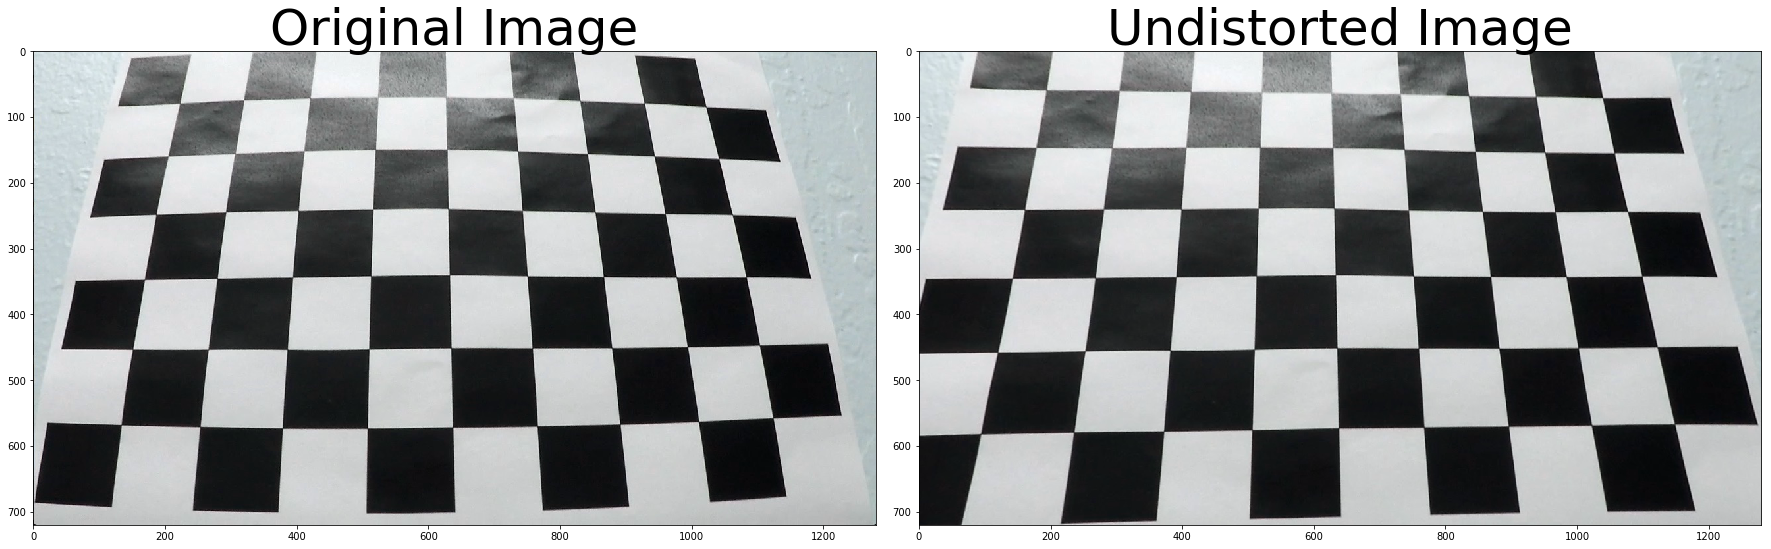

In [11]:

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')    

imgpoints, objpoints = GetImageAndObjectPoints(images, doPlots=False) 

# Use the objpoints and imgpoints found to Calibrate the camera and show result in an example image
img = cv2.imread(images[4])
img_undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Use color and gradient transforms to obtain a binary image
In the following, I use the following techniques to obtain a good binary image of the road:
* Color transform to HSV, using the S channel (best result)
* Then I run a canny transform to get a good binary image
* Merge the transformed images to a best candidate

In [12]:
# Borrowed from the project-1
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [120]:
# Load Test images and undistort
testImages = glob.glob('./test_images/*.jpg') 
img = cv2.imread(testImages[4])
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

In [121]:
# Use blurring and canny transform to obtain a trhesholding image
low_threshold  = 100
high_threshold = 200
# Gausian filter image for removing noise edges
img_canny = cv2.GaussianBlur(img_undist, (7, 7), 0)
# Canny edge detection
img_canny = cv2.Canny(img_canny, low_threshold, high_threshold)

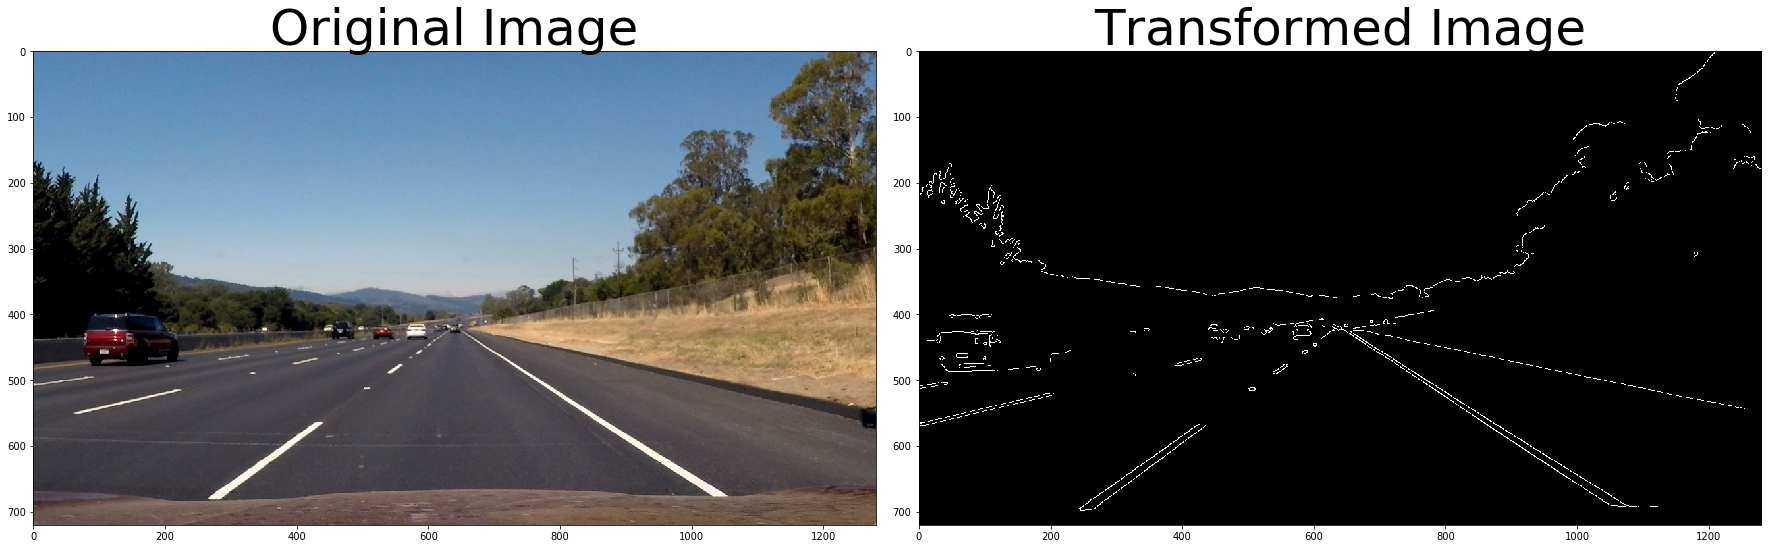

In [122]:

# Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_canny,'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [123]:
# Use Color transform to obtain a threshold image
Col_Thres = 150
img_hls = cv2.cvtColor(img_undist, cv2.COLOR_BGR2HLS)
h = img_hls[:,:,0]
l = img_hls[:,:,1]
s = img_hls[:,:,2]
h_channel = np.zeros_like(h)
l_channel = np.zeros_like(h)
s_channel = np.zeros_like(h)
h_channel[h > Col_Thres] = 255
l_channel[l > Col_Thres] = 255
s_channel[s > Col_Thres] = 255

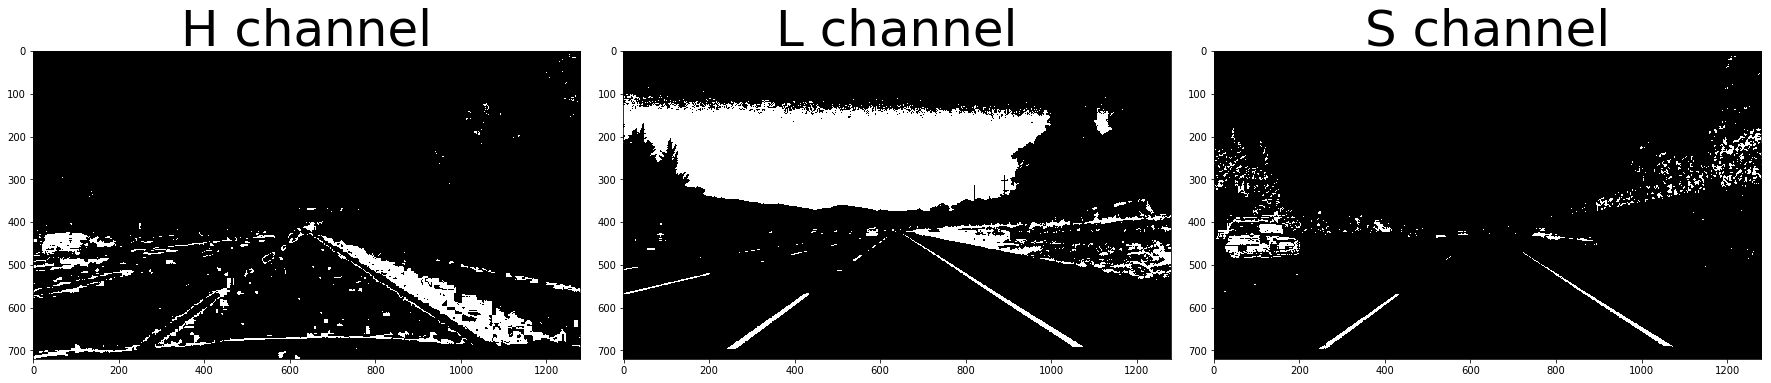

In [124]:
# Plot results
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(h_channel,'gray')
ax1.set_title('H channel', fontsize=50)
ax2.imshow(l_channel,'gray')
ax2.set_title('L channel', fontsize=50)
ax3.imshow(s_channel,'gray')
ax3.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

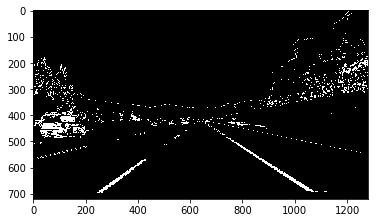

In [125]:
# Combine images

img_binary = np.zeros_like(s_channel)
img_binary[s_channel.nonzero()] = 255
img_binary[img_canny.nonzero()] = 255
plt.imshow(img_binary,'gray')

## Apply a perspective transform to rectify binary image ("birds-eye view")


720


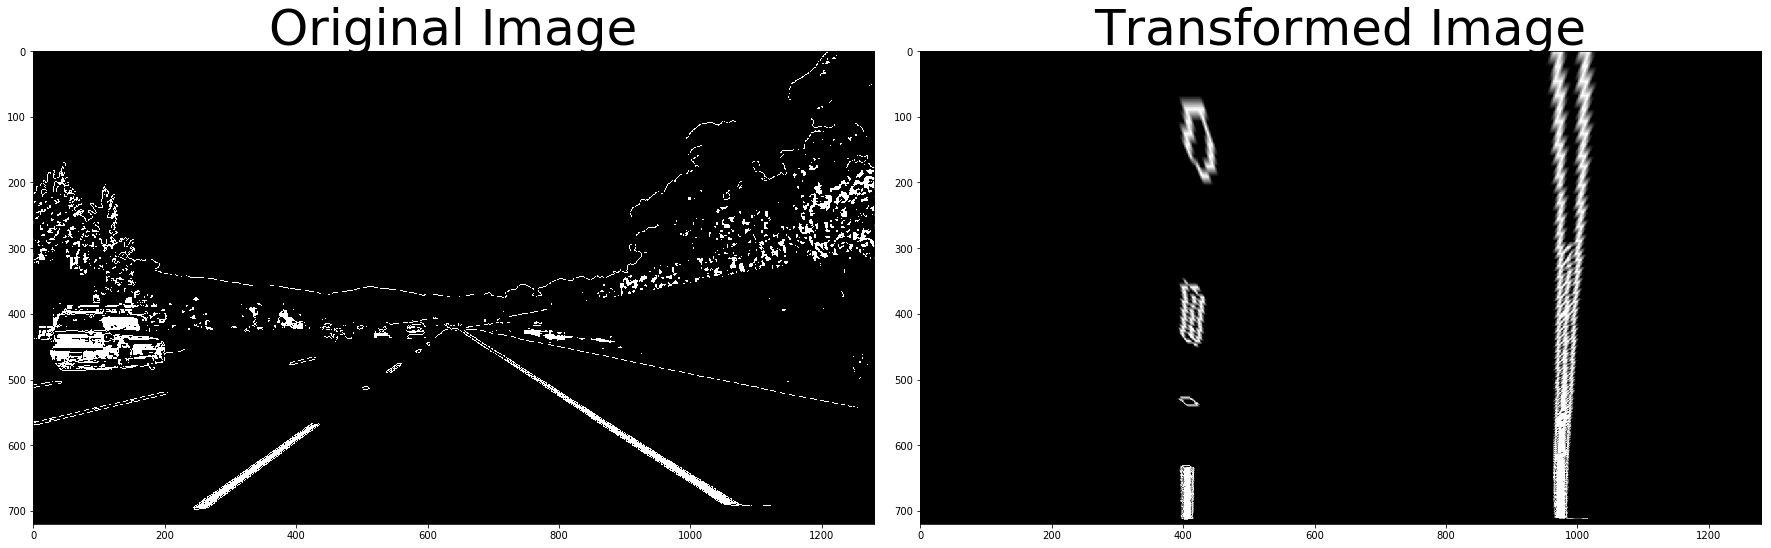

In [130]:
# Define some source points for perspective transform
dimY, dimX = img_binary.shape
print(dimY)
src = np.float32([(210, dimY),(600-10, 450),(700-10, 450),(1150, dimY)])
# destination points
dst = np.float32([(400, dimY),(400, 0),(1000, 0),(1000, dimY)])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
img_warped = cv2.warpPerspective(img_binary, M, (dimX, dimY))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.imshow(img_warped,'gray')
f.tight_layout()
ax1.imshow(img_binary,'gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_warped,'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [119]:
print(testImages[4])

./test_images/straight_lines2.jpg
